## DA labels
I want to explore tagging the utterances with DA labels... These are from NXT. Let's look at them 


In [2]:
import json
import numpy as np
import pandas as pd

from glob import glob
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

In [197]:
# Get turn-segmented data (from TTD)
# from ttd_utils
def read_json(path, encoding="utf8"):
    with open(path, "r", encoding=encoding) as f:
        data = json.loads(f.read())
    return data

wts_path = '/disk/scratch/swallbridge/TurnGPT/data/switchboard/dialogs_turn_level'
wts_files = glob(wts_path + '/*')

wts_dialogues = {}
wts_turns = []
for file in tqdm(wts_files):
    conv_id = file.split('/')[-1][:-5]
    
    turns = read_json(file)
    wts_dialogues[conv_id] = turns
    wts_turns.extend(turns)

  0%|          | 0/2435 [00:00<?, ?it/s]

In [198]:
# wts_turns[0]
# with open('./spoken_data/wts_nxt_info_val_test.pkl', 'rb') as fp:
#     wts_test_turns = pickle.load(fp)
    

In [199]:
len(wts_dialogues.keys())

2435

In [200]:
# Get the DA labels
da_path = '/group/project/cstr1/mscslp/2019-20/clai/switchboard/trans_all'
da_files = glob(da_path + '/*')
print(len(da_files))

da_files[:3]


642


['/group/project/cstr1/mscslp/2019-20/clai/switchboard/trans_all/sw4023.da.txt',
 '/group/project/cstr1/mscslp/2019-20/clai/switchboard/trans_all/sw4628.da.txt',
 '/group/project/cstr1/mscslp/2019-20/clai/switchboard/trans_all/sw2383.da.txt']

In [274]:
def conv_to_words(conv):
    """Return a list of dicts for each word from a list of TTD turn segements"""
    word_list = []
    for i, turn in enumerate(conv):
        words = turn['text'].split(' ')
        for j, w in enumerate(words):
            word_list.append({
                'word': w.lower(), 
                'start': turn['starts'][j],
                'end': turn['ends'][j],
                'speaker': turn['speaker_id'],
                'conv_id': conv_id,
                'turn_id': i
            })
    return word_list

def RLE(myList):
    # I will save the da tags as RLE format
    my_list = list(myList)

    if len(my_list) == 1:
        return([(my_list[0], 1)])

    if len(set(my_list)) == 1:
        return([(my_list[0], len(my_list))])

    aList = []
    count = 1
    for i in range(1, len(my_list)):
        if my_list[i] == my_list[i - 1]:
            count = count + 1
        else:
            aList.append((my_list[i - 1], count))
            count = 1
#             if i == len(my_list) - 1:
#                 aList.append((my_list[i], count))
    aList.append((my_list[-1], count))

#     print(len(my_list), sum([q[1] for q in aList]))
#     print(my_list)
#     print(aList)
    return aList

def string_join(my_list):
    return ' '.join(list(my_list))

def max_da(das):
    """Return the max DA from list of RLE tuples"""
    return  max(das, key=lambda item:item[1])[0] 

def speaker_to_letter(s_list):
    convert = {0: 'A', 1: 'B'}
    return convert[list(s_list)[0]]

def add_da_to_conv(conv_id, segmented_dialogues):

    ## Get the da tag information for the conversation as a df
    da_file = f'/group/project/cstr1/mscslp/2019-20/clai/switchboard/trans_all/{conv_id}.da.txt'
    da_df = pd.read_csv(da_file, header=None, sep='\t')
    da_df = da_df.drop([9], axis=1)

    # Format the df
    rename_cols = {
        0: 'DA', 
        1: 'speaker', 
        2: 'word_id', 
        3: 'utter_id',
        4: '_t1', 
        5: '_t2', 
        6: 'start', 
        7: 'end', 
        8: 'word',
    }
    da_df=da_df.rename(columns=rename_cols)
    da_df['word'] = da_df['word'].str.lower() # to match the DA labels
    da_df = da_df.sort_values(by=['start']) # temporal order
    da_df['start_round'] = da_df.start.round(3) # To deal with different precision of start times from NXT?

    
    ## Get the turn-segmented conversation and convert to word-level df 
    conv = wts_dialogues[conv_id]
    conv_words = conv_to_words(conv)            

    conv_df = pd.DataFrame(conv)
    word_df = pd.DataFrame(conv_words)
    word_df['start_round'] = word_df.start.round(3) # To deal with different precision of start times from NXT?
    
    ## Merge them on 'start_round'
    raw_word_da_df = word_df.merge(da_df[['start_round','DA','word']], how="left", on=['start_round']) #, 'end'])
    raw_word_da_df.head(50)
    
    word_da_df = raw_word_da_df.drop(labels=['word_y'], axis=1)
    word_da_df = word_da_df.drop_duplicates()
    word_da_df.fillna('NAN', inplace=True)
    
    ## Convert back to conversation format
    agg_functions = {'word_x': string_join, # define how to aggregate various fields 
                     'start': 'first', 
                     'end': 'last', 
                     'speaker': speaker_to_letter,  # speaker should be a letter.
                     'conv_id': 'first',
                     'DA': RLE,
                     'turn_id': 'first',
                    }
    
    # create new DataFrame by combining rows with same id values
    conv_da_df = word_da_df.groupby(word_da_df['turn_id']).aggregate(agg_functions)
    conv_da_df['max_DA'] = conv_da_df['DA'].apply(max_da)
    
    conv_da_df = conv_da_df.rename(columns={'word_x': 'clean_text', 'end':'stop'})
    
    return conv_df, conv_da_df, raw_word_da_df
    

In [275]:
conv_df, conv_da_df, raw_word_da_df = add_da_to_conv('sw4023', wts_dialogues)

In [276]:
conv_da_df.columns

Index(['clean_text', 'start', 'stop', 'speaker', 'conv_id', 'DA', 'turn_id',
       'max_DA'],
      dtype='object')

In [277]:
conv_df

,text,starts,ends,speaker_id,start
0,so Martin how do you feel about crime in the c...,"[0.465875, 0.716, 0.986, 1.086, 1.166, 1.276, ...","[0.716, 0.986, 1.086, 1.166, 1.276, 1.416, 1.6...",0,0.465875
1,right i i i actually i live in the city,"[3.889625, 4.2245, 4.366, 4.58825, 4.6645, 4.9...","[4.2245, 4.366, 4.58825, 4.6645, 4.9345, 5.004...",1,3.889625
2,mhm,[6.05275],[6.41925],0,6.052750
3,and uh i guess it is a concern of mine uh you ...,"[6.1985, 6.405625, 6.730125, 6.8845, 7.1345, 7...","[6.405625, 6.730125, 6.8845, 7.1345, 7.2245, 7...",1,6.198500
4,mhm i mean do you find do you find crime in At...,"[12.201375, 13.1875, 13.2375, 13.3775, 13.4375...","[12.441, 13.2375, 13.3775, 13.4375, 13.4975, 1...",0,12.201375
...,...,...,...,...,...
71,was about three grand to put everything togeth...,"[275.1045, 275.25175, 275.52175, 275.74175, 27...","[275.25175, 275.52175, 275.74175, 276.16175, 2...",1,275.104500
72,oh,[280.744125],[281.0865],0,280.744125
73,yeah you've got to you crack the steering colu...,"[281.815125, 281.878375, 282.018375, 282.14837...","[281.878375, 282.018375, 282.148375, 282.22837...",1,281.815125
74,mhm,[286.64875],[286.897625],0,286.648750


In [110]:
nxt_conv_ids = [da_file.split('/')[-1][:6] for da_file in da_files]
wts_conv_ids = list(wts_dialogues.keys())

In [114]:
len(wts_conv_ids), len(nxt_conv_ids)
[c for c in nxt_conv_ids if c not in wts_conv_ids]

['sw4379']

In [117]:




words_df = pd.DataFrame()
convs_df = pd.DataFrame()
convs_da_df = pd.DataFrame() 
raw_words_da_df = pd.DataFrame() 

for conv_id in tqdm(nxt_conv_ids):
    if conv_id in wts_conv_ids: # one dialogue is missing...
        conv = wts_dialogues[conv_id]
        conv_words = conv_to_words(conv)            

        conv_df = pd.DataFrame(conv)
        word_df = pd.DataFrame(conv_words)

        conv_df, conv_da_df, raw_word_da_df = add_da_to_conv(conv_id, wts_dialogues)

        convs_df = convs_df.append(conv_df, ignore_index=True)
        words_df = words_df.append(word_df, ignore_index=True)
        convs_da_df = convs_da_df.append(conv_da_df, ignore_index=True)
        raw_words_da_df = raw_words_da_df.append(raw_word_da_df, ignore_index=True)

    
# To deal with different precision of start times from NXT?
# words_df['start_round'] = word_df.start.round(3)


  0%|          | 0/642 [00:00<?, ?it/s]

In [118]:
raw_words_da_df.head()


,word_x,start,end,speaker,conv_id,turn_id,start_round,DA,word_y
0,so,0.465875,0.716,0,sw4023,0,0.466,NaN,NaN
1,martin,0.716000,0.986,0,sw4023,0,0.716,NaN,NaN
2,how,0.986000,1.086,0,sw4023,0,0.986,open_q,how
3,do,1.086000,1.166,0,sw4023,0,1.086,open_q,do
4,you,1.166000,1.276,0,sw4023,0,1.166,open_q,you


In [119]:
convs_da_df.head()


,word_x,start,end,speaker,conv_id,DA
0,so martin how do you feel about crime in the c...,0.465875,3.905125,0,sw4023,"[(NAN, 2), (open_q, 9), (NAN, 1), (statement, 5)]"
1,right i i i actually i live in the city,3.889625,5.877375,1,sw4023,"[(agree, 1), (statement, 9)]"
2,mhm,6.052750,6.419250,0,sw4023,"[(backchannel, 1)]"
3,and uh i guess it is a concern of mine uh you ...,6.198500,11.679000,1,sw4023,"[(statement, 17)]"
4,mhm i mean do you find do you find crime in at...,12.201375,15.986250,0,sw4023,"[(backchannel, 1), (yn_q, 4), (NAN, 1), (yn_q,..."


# ANALYSIS
1. Check how many of the back channels don't match. Are there any that are actually different 
    (ie, where the replaced word gets a different tag?)
    
Eriks cleaning means that "uh-huh" and "huh-uh" get mapped to the same word "uhuh". I want to check if there are any instances of the cleaned tag that get mapped to different DAs

2. How many words are not given a tag? How many turns are not given a tag?

In [123]:
# ANALYSIS
# 1. Check how many of the back channels don't match. Are there any that are actually different 
#     (ie, where the replaced word gets a different tag?)

SWB_WORD_MAP = {
    "uh-huh": "uhuh",
    "huh-uh": "uhuh",
    "uh-hum": "mhm",
    "uh-hums": "mhm",
    "um-hum": "mhm",
    "hum-um": "mhm",
    "uh-oh": "uhoh",
}
from collections import Counter


for word in set(list(SWB_WORD_MAP.values())):
    print(f'\nWord: {word}')

    c_replaced_word = Counter(list(raw_words_da_df[raw_words_da_df.word_x == word].word_y))
    c_tag = Counter(list(raw_words_da_df[raw_words_da_df.word_x == word].DA))
    
    display(c_replaced_word)
    display(c_tag)



Word: mhm


Counter({'uh-huh': 2500,
         'uh-hum': 2,
         'um-hum': 4,
         nan: 172,
         'um': 7,
         'huh-uh': 55,
         'yeah': 4,
         'uh': 5,
         'well': 1,
         'god': 1,
         "'s": 2,
         'that': 2,
         'huh': 2,
         'yes': 1,
         'uh-uh': 2,
         'right': 3,
         'what': 1,
         'oh': 1})

Counter({'backchannel': 2370,
         nan: 172,
         'yes': 57,
         'uninterp': 11,
         'agree': 96,
         'yn_q': 1,
         'close': 4,
         'acknowledge': 9,
         'excluded': 16,
         'statement': 4,
         'neg': 1,
         'hold': 1,
         'opinion': 7,
         'no': 8,
         'repeat': 5,
         'answer': 1,
         'quote': 1,
         'other': 1})


Word: uhoh


Counter({'uh-oh': 4, 'oh': 1, 'uh-huh': 1, nan: 1})

Counter({'backchannel': 5, 'apprec': 1, nan: 1})


Word: uhuh


Counter({'uh': 7,
         'uh-huh': 2975,
         nan: 122,
         'i': 3,
         'um': 2,
         'uh-uh': 3,
         'and': 2,
         'huh-uh': 80,
         'is': 1,
         'oh': 2,
         'huh': 3,
         'well': 1,
         'huh-huh': 1,
         'yeah': 3,
         'okay': 1,
         'but': 1,
         'right': 1,
         "'s": 1,
         'to': 1,
         "'ve": 1,
         'you': 1})

Counter({'uninterp': 14,
         'backchannel': 2749,
         'excluded': 33,
         'agree': 83,
         nan: 122,
         'statement': 16,
         'yes': 119,
         'close': 5,
         'repeat': 6,
         'acknowledge': 19,
         'no': 32,
         'yn_q': 2,
         'opinion': 3,
         'ans_dispref': 1,
         'other': 1,
         'reject': 1,
         'abandon': 3,
         'apprec': 1,
         'third_pty': 2})

DA counts for raw_words
NaNs: 14495 / 814494 (1.78)
DA counts for convs
NaNs: 818 / 49217 (1.66)


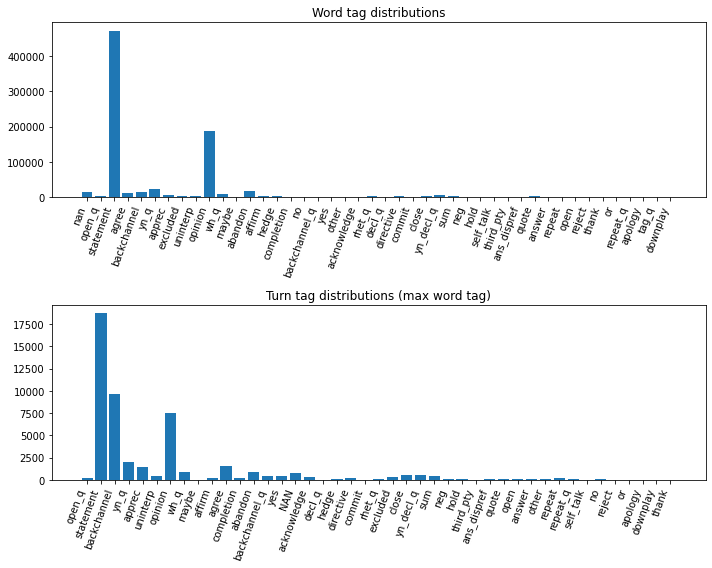

In [174]:
# 2. How many words are not given a tag? 
raw_words_counter = Counter(raw_words_da_df.DA)
print('DA counts for raw_words')
the_nan = list(raw_words_counter.keys())[0]
print(f'NaNs: {raw_words_counter[the_nan]} / {sum(raw_words_counter.values())} ({(raw_words_counter[the_nan] * 100) / sum(raw_words_counter.values()):.2f})')

# How many turns are not given a tag?
convs_da_df['max_DA'] = convs_da_df['DA'].apply(max_da)
convs_counter = Counter(convs_da_df.max_DA)
the_nan = 'NAN'
print('DA counts for convs')
print(f'NaNs: {convs_counter[the_nan]} / {sum(convs_counter.values())} ({(convs_counter[the_nan] * 100) / sum(convs_counter.values()):.2f})')

fig, axes = plt.subplots(2,1,figsize=(10,8))
axes[0].bar([str(l) for l in list(raw_words_counter.keys())], raw_words_counter.values())  
axes[0].set_title('Word tag distributions')
axes[1].bar([str(l) for l in list(convs_counter.keys())], convs_counter.values()) 
axes[1].set_title('Turn tag distributions (max word tag)')

plt.setp(axes[0].get_xticklabels(), rotation=70, horizontalalignment='right')
plt.setp(axes[1].get_xticklabels(), rotation=70, horizontalalignment='right')
plt.tight_layout()
plt.show()


In [175]:
convs_da_df[convs_da_df['max_DA'] == 'NAN']

,word_x,start,end,speaker,conv_id,DA,max_DA
72,oh,280.744125,281.086500,0,sw4023,"[(NAN, 1)]",NAN
242,um,77.770625,78.095625,0,sw3088,"[(NAN, 1)]",NAN
494,but,296.737500,297.276500,1,sw2299,"[(NAN, 1)]",NAN
555,uhuh,87.615000,88.049000,1,sw2427,"[(NAN, 1)]",NAN
593,yeah,212.909750,213.339750,1,sw2427,"[(NAN, 1)]",NAN
...,...,...,...,...,...,...,...
48955,well what club,205.846000,206.371875,0,sw4928,"[(NAN, 2), (wh_q, 1)]",NAN
48991,okay let's see that's north,50.943250,52.502750,1,sw2832,"[(backchannel, 1), (NAN, 4)]",NAN
49011,mhm,134.189875,134.658625,1,sw2832,"[(NAN, 1)]",NAN
49020,uhuh,167.980375,168.370375,0,sw2832,"[(NAN, 1)]",NAN


# Make DA datasets in BERT-FP style 

In [179]:
def read_json(path, encoding="utf8"):
    with open(path, "r", encoding=encoding) as f:
        data = json.loads(f.read())
    return data

speaker_channel = {0: 'A', 1: 'B'}

def convert_turns_into_objects(turns, conv_id):
    new_turns = []
    for i, t in enumerate(turns):
        new_turn = {
            'conv_id': 'sw0' + conv_id[-4:],
            'speaker': speaker_channel[t['speaker_id']],
            'turn_id': i, 
            'start': t['starts'][0],
            'stop': t['ends'][-1],
            'clean_text': t['text'],
        }
        new_turns.append(new_turn)
    return new_turns

# For Word-Time-Stamp (wts) turns
wts_path = '/disk/scratch/swallbridge/TurnGPT/data/switchboard/dialogs_turn_level'
wts_files = glob(wts_path + '/*')

wts_dialogues = {}
wts_turns = []
for file in tqdm(wts_files):
    conv_id = file.split('/')[-1][:-5]
    
    turns = read_json(file)
    new_turns = convert_turns_into_objects(turns, conv_id)
    wts_turns.extend(new_turns)

  0%|          | 0/2435 [00:00<?, ?it/s]

In [181]:
# from conversational_corpus import ConversationTranscripts
# wts_corpus = ConversationTranscripts(transcripts_path=None, conversation_fn=None, conv_num=len(wts_dialogues))
# wts_corpus.conv_turns = wts_turns

wts_turn_df = pd.DataFrame(wts_turns)

In [183]:
# Split conversation ids into train, test, val based on NXT labels
da_path = '/group/project/cstr1/mscslp/2019-20/clai/switchboard/trans_all'
nxt_files = glob (da_path + '/*')
nxt_conv_ids = ['sw0' + f.split('/')[-1][2:6] for f in nxt_files]
print(f'Number of nxt files: {len(nxt_files)}')

wts_train_nxt = [t for t in set(list(wts_turn_df.conv_id)) if t not in nxt_conv_ids]
wts_val_nxt, wts_test_nxt = train_test_split(nxt_conv_ids, test_size=0.5, random_state=1)

print(f'total files: {len(wts_train_nxt) + len(wts_val_nxt)+ len(swb_test_nxt)}')
print(f'train files: {len(wts_train_nxt)/len(set(list(wts_turn_df.conv_id))):.3f}% ({len(swb_train_nxt)})')
print(f'valid files: {len(wts_val_nxt)/len(set(list(wts_turn_df.conv_id))):.3f}% ({len(swb_val_nxt)})')
print(f'test  files: {len(wts_test_nxt)/len(set(list(wts_turn_df.conv_id))):.3f}% ({len(swb_test_nxt)})')

Number of nxt files: 642
total files: 2436
train files: 0.737% (1794)
valid files: 0.132% (321)
test  files: 0.132% (321)


In [184]:
wts_train_df = wts_turn_df[wts_turn_df.conv_id.isin(swb_train_nxt)]
wts_val_df = wts_turn_df[wts_turn_df.conv_id.isin(swb_val_nxt)]
wts_test_df = wts_turn_df[wts_turn_df.conv_id.isin(swb_test_nxt)]

In [290]:
def make_meta_da_dataset(turns_df):
    """
    Instead of a list of turns, return a list of dicts (each dict is a turn object)
    """
    conv_ids = list(set(turns_df.conv_id))
    result = {}
    for cid in tqdm(conv_ids):
        try:
            cid = f'sw{cid[-4:]}'
            conv_df, conv_da_df, raw_word_da_df = add_da_to_conv(cid, wts_dialogues)
            cdf = conv_da_df
    #         cdf = turns_df.groupby('conv_id').get_group(cid)
            result[cid] = cdf.to_dict('records') #[cols].to_dict('records')
        except Exception as e: print(e) 
    return result

In [292]:
# conv_df, conv_da_df, raw_word_da_df = add_da_to_conv(conv_ids[0], wts_dialogues)

In [293]:
# RENAME word_x to clean_text, end to stop, keep turn_id, speaker should be a letter.
# conv_da_df.to_dict('records')

In [295]:
# Add DA information to the validation and test sets
wts_val_info_dict = make_meta_da_dataset(wts_val_df)
wts_test_info_dict = make_meta_da_dataset(wts_test_df)

wts_val_turns_info = list(wts_val_info_dict.values())
wts_test_turns_info = list(wts_test_info_dict.values())

  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

In [296]:
# with open('spoken_data/wts_nxt_info_da_val.pkl', 'wb') as fp:
#     pickle.dump(wts_val_turns_info, fp)
    
# with open('spoken_data/wts_nxt_info_da_test.pkl', 'wb') as fp:
#     pickle.dump(wts_test_turns_info, fp)

In [228]:
with open('spoken_data/wts_nxt_info_train.pkl', 'rb') as fp:
    wts_train_turns_info_loaded = pickle.load(fp)
    
with open('spoken_data/wts_nxt_info_val.pkl', 'rb') as fp:
    wts_val_turns_info_loaded = pickle.load(fp)
    
with open('spoken_data/wts_nxt_info_test.pkl', 'rb') as fp:
    wts_test_turns_info_loaded = pickle.load(fp)

In [229]:
test_df = pd.DataFrame(wts_val_turns_info_loaded[0])

In [202]:
conv_df, conv_da_df, raw_word_da_df = add_da_to_conv('sw2785', wts_dialogues)

# DEV

In [192]:
# Read a da file
# da_file = da_files[10]
# conv_id = da_file.split('/')[-1][:6]
# print(conv_id)

conv_id = 'sw2785'
da_file = f'/group/project/cstr1/mscslp/2019-20/clai/switchboard/trans_all/{conv_id}.da.txt'

da_df = pd.read_csv(da_file, header=None, sep='\t')
da_df = da_df.drop([9], axis=1)

# Format the df
rename_cols = {
    0: 'DA', 
    1: 'speaker', 
    2: 'word_id', 
    3: 'utter_id',
    4: '_t1', 
    5: '_t2', 
    6: 'start', 
    7: 'end', 
    8: 'word',
}
da_df=da_df.rename(columns=rename_cols)
da_df['word'] = da_df['word'].str.lower() # to match the DA labels
da_df = da_df.sort_values(by=['start']) # temporal order
da_df['start_round'] = da_df.start.round(3) # To deal with different precision of start times from NXT?



In [193]:
da_df.head()

,DA,speaker,word_id,utter_id,_t1,_t2,start,end,word,start_round
0,other,A,sw2785A-ms98-a-0002-5,sw2785A-ms98-a-0002,0.268375,0.984750,0.268375,0.984750,okay,0.268
1,statement,A,sw2785A-ms98-a-0002-7,sw2785A-ms98-a-0002,1.421625,1.708375,1.421625,1.708375,uh,1.422
2,statement,A,sw2785A-ms98-a-0002-8,sw2785A-ms98-a-0002,1.708375,NaN,1.708375,1.998375,we,1.708
3,statement,A,sw2785A-ms98-a-0002-8,sw2785A-ms98-a-0002,NaN,1.998375,1.708375,1.998375,'re,1.708
4,statement,A,sw2785A-ms98-a-0002-9,sw2785A-ms98-a-0002,1.998375,2.198375,1.998375,2.198375,going,1.998


In [194]:
# Read in the wts_dialogue and convert it to word-level...
conv = wts_dialogues[conv_id]

def conv_to_words(conv):
    """Return a list of dicts for each word from a list of TTD turn segements"""
    word_list = []
    for i, turn in enumerate(conv):
        words = turn['text'].split(' ')
        for j, w in enumerate(words):
            word_list.append({
                'word': w.lower(), 
                'start': turn['starts'][j],
                'end': turn['ends'][j],
                'speaker': turn['speaker_id'],
                'conv_id': conv_id,
                'turn_id': i
            })
    return word_list

# def da_words_to_turns(df):
#     """Given a df of words in a conversation, convert back to turn dicts"""


KeyError: 'sw2785'

In [196]:

wts_dialogues.keys()


# nxt_conv_ids = [da_file.split('/')[-1][:6] for da_file in da_files]

# words_df = pd.DataFrame()
# convs_df = pd.DataFrame()

# for conv in nxt_conv_ids[:10]:
#     conv = wts_dialogues[conv_id]
#     conv_words = conv_to_words(conv)            

#     conv_df = pd.DataFrame(conv)
#     word_df = pd.DataFrame(conv_words)
    
#     convs_df = convs_df.append(conv_df, ignore_index=True)
#     words_df = words_df.append(word_df, ignore_index=True)
# To deal with different precision of start times from NXT?
# words_df['start_round'] = word_df.start.round(3)


dict_keys([])

In [87]:
conv_df = pd.DataFrame(conv)
word_df = pd.DataFrame(conv_words)
word_df['start_round'] = word_df.start.round(3)


In [88]:
da_df

,DA,speaker,word_id,utter_id,_t1,_t2,start,end,word,start_round
0,open_q,A,sw4023A-ms98-a-0002-7,sw4023A-ms98-a-0002,0.986000,1.086000,0.986000,1.086000,how,0.986
1,open_q,A,sw4023A-ms98-a-0002-8,sw4023A-ms98-a-0002,1.086000,1.166000,1.086000,1.166000,do,1.086
2,open_q,A,sw4023A-ms98-a-0002-9,sw4023A-ms98-a-0002,1.166000,1.276000,1.166000,1.276000,you,1.166
3,open_q,A,sw4023A-ms98-a-0002-10,sw4023A-ms98-a-0002,1.276000,1.416000,1.276000,1.416000,feel,1.276
4,open_q,A,sw4023A-ms98-a-0002-11,sw4023A-ms98-a-0002,1.416000,1.626000,1.416000,1.626000,about,1.416
...,...,...,...,...,...,...,...,...,...,...
1013,statement,B,sw4023B-ms98-a-0074-749,sw4023B-ms98-a-0074,297.311375,297.506250,297.311375,297.506250,had,297.311
1014,statement,B,sw4023B-ms98-a-0074-750,sw4023B-ms98-a-0074,297.506250,297.834625,297.506250,297.834625,to,297.506
1015,statement,B,sw4023B-ms98-a-0074-752,sw4023B-ms98-a-0074,298.175250,298.231375,298.175250,298.231375,i,298.175
1016,statement,B,sw4023B-ms98-a-0074-753,sw4023B-ms98-a-0074,298.231375,298.361375,298.231375,298.361375,had,298.231


In [89]:
da_df[da_df.word_id.str.contains(conv_id)].head(25)

,DA,speaker,word_id,utter_id,_t1,_t2,start,end,word,start_round
0,open_q,A,sw4023A-ms98-a-0002-7,sw4023A-ms98-a-0002,0.986000,1.086000,0.986000,1.086000,how,0.986
1,open_q,A,sw4023A-ms98-a-0002-8,sw4023A-ms98-a-0002,1.086000,1.166000,1.086000,1.166000,do,1.086
2,open_q,A,sw4023A-ms98-a-0002-9,sw4023A-ms98-a-0002,1.166000,1.276000,1.166000,1.276000,you,1.166
3,open_q,A,sw4023A-ms98-a-0002-10,sw4023A-ms98-a-0002,1.276000,1.416000,1.276000,1.416000,feel,1.276
4,open_q,A,sw4023A-ms98-a-0002-11,sw4023A-ms98-a-0002,1.416000,1.626000,1.416000,1.626000,about,1.416
5,open_q,A,sw4023A-ms98-a-0002-12,sw4023A-ms98-a-0002,1.626000,1.956000,1.626000,1.956000,crime,1.626
6,open_q,A,sw4023A-ms98-a-0002-13,sw4023A-ms98-a-0002,1.956000,2.076000,1.956000,2.076000,in,1.956
7,open_q,A,sw4023A-ms98-a-0002-14,sw4023A-ms98-a-0002,2.076000,2.146000,2.076000,2.146000,the,2.076
8,open_q,A,sw4023A-ms98-a-0002-15,sw4023A-ms98-a-0002,2.146000,2.594000,2.146000,2.594000,city,2.146
9,statement,A,sw4023A-ms98-a-0002-17,sw4023A-ms98-a-0002,2.766000,2.926000,2.766000,2.926000,you,2.766


In [285]:
# # Merge the ttd word level objects with DAs where possible (start and end times match!)
# raw_word_da_df = word_df.merge(da_df[['start_round','DA','word']], how="left", on=['start_round']) #, 'end'])
# raw_word_da_df.head(50)
# print(raw_word_da_df.shape)

# # ANALYSIS
# # 1. Check how many of the back channels don't match. Are there any that are actually different 
# #     (ie, where the replaced word gets a different tag?)
# # Eriks cleaning means that "uh-huh" and "huh-uh" get mapped to the same word "uhuh". I want to check if there are any instances of the cleaned tag that get mapped to different DAs
# # word_da_df[word_da_df.word_x == 'mhm']
# # word_da_df[word_da_df.word_x == 'uhuh']

# # 2. How many words are not given a tag? How many turns are not given a tag?

# # Keep words from word_df (wts data), and remove duplicates
# word_da_df = raw_word_da_df.drop(labels=['word_y'], axis=1)
# word_da_df = word_da_df.drop_duplicates()

# word_da_df.fillna('NAN', inplace=True)

# print(word_da_df.shape)





In [284]:
# # Convert back into conversation format

# # I will save the da tags as RLE format
# def RLE(myList):
#     my_list = list(myList)

#     if len(my_list) == 1:
#         return([(my_list[0], 1)])
    
#     if len(set(my_list)) == 1:
#         return([(my_list[0], len(my_list))])
    
#     aList = []
#     count = 1
#     for i in range(1, len(my_list)):
#         if my_list[i] == my_list[i - 1]:
#             count = count + 1
#         else:
#             aList.append((my_list[i - 1], count))
#             count = 1
# #             if i == len(my_list) - 1:
# #                 aList.append((my_list[i], count))
#     aList.append((my_list[-1], count))
                
# #     print(len(my_list), sum([q[1] for q in aList]))
# #     print(my_list)
# #     print(aList)
#     return aList

# def string_join(my_list):
#     return ' '.join(list(my_list))


# #define how to aggregate various fields
# agg_functions = {'word_x': string_join, 
#                  'start': 'first', 
#                  'end': 'last', 
#                  'speaker': 'first', 
#                  'conv_id': 'first',
#                  'DA': RLE,
#                 }

# #create new DataFrame by combining rows with same id values
# conv_da_df = word_da_df.groupby(word_da_df['turn_id']).aggregate(agg_functions)

# # conv_da_df = word_da_df.groupby('turn_id', sort=False) #['word_x'].apply(' '.join)
# conv_da_df.head(20)


In [76]:
# display(word_df[word_df.word=='pretty'].start)
# display(da_df[da_df.word=='pretty'].start) #], how="left", on=['start']) #, 'end']))

# print(list(word_df[word_df.word=='punishment'].start)[0])
# print(list(da_df[da_df.word=='punishment'].start)[0])

In [77]:
# word_df.info()

In [78]:
# # I want to be able to write the DAs to the bert_fp meta datasets format

# # def make_meta_dataset(turns_df):
# #     """
# #     Instead of a list of turns, return a list of dicts (each dict is a turn object)
# #     """
# #     conv_ids = list(set(turns_df.conv_id))
# #     result = {}
# #     for cid in tqdm(conv_ids):
# #         cdf = turns_df.groupby('conv_id').get_group(cid)
# #         result[cid] = cdf.to_dict('records') #[cols].to_dict('records')
# #     return result
# import pickle
# with open('spoken_data/wts_nxt_info_val.pkl', 'rb') as fp:
#     wts_val_turns_info = pickle.load(fp)

In [37]:
# wts_val_turns_info[0]